biof 509 project - 
spring 2020 - 
by Neil Perkins

### Goal: predictors of covid 19

The goal is to explore COVID-19 hospital data to identify predictors of death.

### Data: Official Covid data from Mexican Health Department
    
Independent suspicious and confirmed cases files stopped being distributed by the government on April 18th 2020. Posted on kaggle.com by Eduardo Rojas.

https://www.kaggle.com/lalish99/covid19-mx

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Data

Read in the data

In [2]:
df1mx = pd.read_csv('covid-19_general_MX.csv')
df2cases = pd.read_csv('casos_confirmados.csv')

Data dimensions

In [3]:
df1mx.shape

(95839, 26)

In [4]:
df2cases.shape

(23471, 6)

Data descriptives

In [5]:
type(df1mx)

pandas.core.frame.DataFrame

In [6]:
df1mx.head()

,Unnamed: 0,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,...,INMUSUPR,HIPERTENSION,OTRA_CON,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,UCI
0,0,4,17,2,17,1,2020-03-09,2020-03-09,9999-99-99,97,...,2,2,2,2,2,2,2,99,1,97
1,1,4,9,1,9,1,2020-03-19,2020-03-17,9999-99-99,97,...,2,2,2,2,2,2,2,99,1,97
2,2,4,2,2,2,2,2020-03-19,2020-03-19,9999-99-99,2,...,2,1,2,2,1,2,2,99,1,2
3,3,4,9,2,9,2,2020-03-30,2020-03-24,2020-04-01,2,...,2,2,2,2,2,2,2,99,1,2
4,4,12,14,1,14,2,2020-03-29,2020-03-26,9999-99-99,2,...,2,2,2,2,2,2,2,2,2,2


Rename columns to english

    - could use .rename
    - too many so used .columns to redo entire list

In [7]:
df1mx.columns=['ID','SECTOR','state_care','sex',
               'state_live','ambulatory','care_date',
               'sympt_date','dead_date','intubate',
               'neumonia','age','nation','diabetes',
               'epoch','asthma','immunosprs','hyperten',
               'OtherDis','CardioDis','Obesity','RenalDis',
               'tabaquism','COVID_contact','COVID','ICU']

Look for missing data

In [8]:
df1na=df1mx.isna()

In [9]:
df1na.describe()

,ID,SECTOR,state_care,sex,state_live,ambulatory,care_date,sympt_date,dead_date,intubate,...,immunosprs,hyperten,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID_contact,COVID,ICU
count,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839,...,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839,...,95839,95839,95839,95839,95839,95839,95839,95839,95839,95839


In [10]:
df1mx.isna().sum()

ID               0
SECTOR           0
state_care       0
sex              0
state_live       0
ambulatory       0
care_date        0
sympt_date       0
dead_date        0
intubate         0
neumonia         0
age              0
nation           0
diabetes         0
epoch            0
asthma           0
immunosprs       0
hyperten         0
OtherDis         0
CardioDis        0
Obesity          0
RenalDis         0
tabaquism        0
COVID_contact    0
COVID            0
ICU              0
dtype: int64

Summarize missing data across all variables

    -no missing data
    -if missing data, use .fillna()

No missing data here

    -but... structural missingness exists
    -9999-99-99 for death date for patients who didn't die
    
From Kaggle "Options for yes or no columns"

    1 = Yes
    2 = No
    97 = Does not apply
    98 = Is ignored
    99 = Not specified

In [11]:
df1mxdates=df1mx.iloc[:,6:9]
df1mxdates.shape

(95839, 3)

Create ID for dead from 9999 date

In [12]:
dead = df1mxdates['dead_date'].str.startswith("9")
dead = (dead==False)
df1mx['dead'] = dead*1
df1mx['dead'].describe()


count    95839.000000
mean         0.035841
std          0.185895
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: dead, dtype: float64

In [13]:
from datetime import date, datetime, timedelta
date1 = pd.to_datetime(df1mxdates['care_date'])
date2 = pd.to_datetime(df1mxdates['sympt_date'])
date1 = date1.dt.date
date2 = date2.dt.date

sympt2care = date1 - date2
sympt2care = sympt2care.dt.days

In [14]:
df1mx['sympt2care'] = sympt2care

In [15]:
df1mx.shape

(95839, 28)

In [16]:
df1mx = df1mx.drop(['care_date', 'sympt_date','dead_date'], axis=1)
dead = df1mx['dead']
df1mx = df1mx.drop(['dead'], axis=1)
df1mx['dead'] = dead    #making dead last in the list

In [17]:
df1mx.columns

Index(['ID', 'SECTOR', 'state_care', 'sex', 'state_live', 'ambulatory',
       'intubate', 'neumonia', 'age', 'nation', 'diabetes', 'epoch', 'asthma',
       'immunosprs', 'hyperten', 'OtherDis', 'CardioDis', 'Obesity',
       'RenalDis', 'tabaquism', 'COVID_contact', 'COVID', 'ICU', 'sympt2care',
       'dead'],
      dtype='object')

insert NaN for 97, 98, 99 so the modeling isnt messed up

In [18]:
df1mxna = df1mx.replace(97, value=np.nan)
df1mxna = df1mxna.replace(98, value=np.nan)
df1mxna = df1mxna.replace(99, value=np.nan)
df1mxna.describe()

,ID,SECTOR,state_care,sex,state_live,ambulatory,intubate,neumonia,age,nation,...,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID_contact,COVID,ICU,sympt2care,dead
count,95836.000000,95195.000000,95839.000000,95839.000000,95839.000000,95839.000000,25547.000000,95831.000000,95802.000000,95839.000000,...,95281.000000,95423.000000,95449.000000,95433.000000,95435.000000,60344.000000,95839.000000,25546.000000,95839.000000,95839.000000
mean,47920.496964,8.795042,14.660639,1.508353,14.897620,1.266812,1.924296,1.816051,42.031200,1.012584,...,1.951281,1.968708,1.836593,1.976036,1.902436,1.517947,1.887238,1.914664,3.566262,0.035841
std,27665.619790,3.782903,8.075045,0.499933,8.006973,0.442296,0.264528,0.387444,17.287125,0.111469,...,0.215281,0.174107,0.369738,0.152939,0.296725,0.499682,0.603595,0.279387,3.373566,0.185895
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,23961.750000,4.000000,9.000000,1.000000,9.000000,1.000000,2.000000,2.000000,30.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,47920.500000,12.000000,14.000000,2.000000,14.000000,1.000000,2.000000,2.000000,41.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.000000
75%,71879.250000,12.000000,20.000000,2.000000,20.000000,2.000000,2.000000,2.000000,53.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,0.000000
max,95838.000000,13.000000,32.000000,2.000000,32.000000,2.000000,2.000000,2.000000,113.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,91.000000,1.000000


In [19]:
df1mxna.isna().sum()

ID                   3
SECTOR             644
state_care           0
sex                  0
state_live           0
ambulatory           0
intubate         70292
neumonia             8
age                 37
nation               0
diabetes           417
epoch              404
asthma             409
immunosprs         426
hyperten           402
OtherDis           558
CardioDis          416
Obesity            390
RenalDis           406
tabaquism          404
COVID_contact    35495
COVID                0
ICU              70293
sympt2care           0
dead                 0
dtype: int64

In [20]:
# what to do with missing data
# drop all
df2mx = pd.DataFrame(df1mxna.dropna())

# remove 'intubate','Covid_contact','ICU'--then drop all
df3mx = df1mxna.drop(['intubate', 'COVID_contact','ICU'], axis=1)
df3mx = pd.DataFrame(df3mx.dropna())


In [21]:
df2mx

,ID,SECTOR,state_care,sex,state_live,ambulatory,intubate,neumonia,age,nation,...,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID_contact,COVID,ICU,sympt2care,dead
4,4.0,12.0,14,1,14,2,2.0,2.0,44.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,3,0
7,7.0,12.0,32,2,32,2,2.0,1.0,89.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,1,0
8,8.0,12.0,2,1,2,2,2.0,1.0,34.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0,0
11,11.0,12.0,6,1,6,2,2.0,1.0,7.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,1,0
20,20.0,12.0,14,1,14,2,1.0,1.0,22.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95810,95810.0,6.0,30,1,30,2,2.0,2.0,52.0,1,...,2.0,2.0,1.0,2.0,2.0,2.0,3,2.0,4,0
95819,95819.0,12.0,9,1,9,2,2.0,1.0,66.0,1,...,2.0,2.0,1.0,2.0,2.0,2.0,3,2.0,4,0
95820,95820.0,12.0,15,2,15,2,2.0,1.0,46.0,1,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0,0
95831,95831.0,12.0,15,2,15,2,2.0,1.0,44.0,1,...,2.0,2.0,1.0,2.0,2.0,1.0,3,2.0,1,0


In [22]:
df3mx

,ID,SECTOR,state_care,sex,state_live,ambulatory,neumonia,age,nation,diabetes,...,immunosprs,hyperten,OtherDis,CardioDis,Obesity,RenalDis,tabaquism,COVID,sympt2care,dead
0,0.0,4.0,17,2,17,1,2.0,42.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,0,0
1,1.0,4.0,9,1,9,1,2.0,51.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,2,0
2,2.0,4.0,2,2,2,2,2.0,51.0,1,1.0,...,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1,0,0
3,3.0,4.0,9,2,9,2,2.0,57.0,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,6,1
4,4.0,12.0,14,1,14,2,2.0,44.0,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95834,95834.0,4.0,23,2,23,2,2.0,59.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,1,0
95835,95835.0,4.0,2,2,2,2,2.0,50.0,1,1.0,...,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3,0,0
95836,95836.0,12.0,27,1,27,2,2.0,65.0,1,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,5,0
95837,95837.0,12.0,15,1,15,1,2.0,48.0,1,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2,0


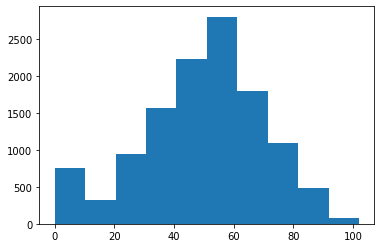

In [23]:
plt.hist(df2mx['age']);

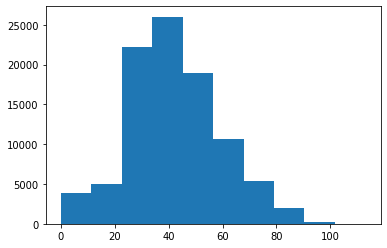

In [24]:
plt.hist(df3mx['age']);

pretty different distributions (shape) of age

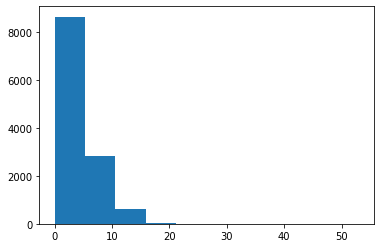

In [25]:
plt.hist(pd.to_numeric(df2mx['sympt2care']));

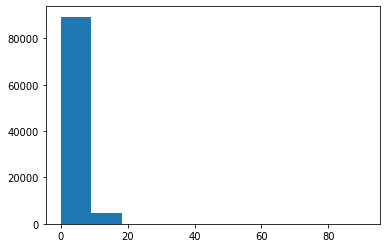

In [26]:
plt.hist(pd.to_numeric(df3mx['sympt2care']));

fairly similar for s2c

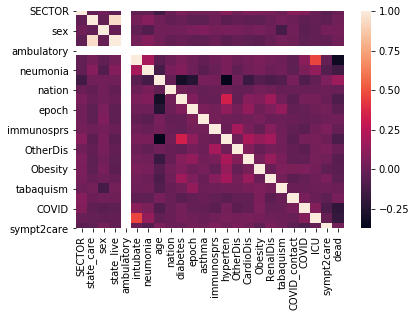

In [27]:
corr = df2mx.iloc[:,1:].corr()
corr_dead = pd.DataFrame(corr['dead'])
sns.heatmap(corr);

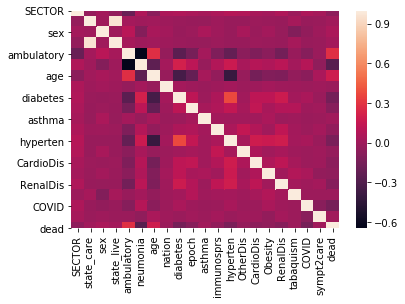

In [28]:
corr = df3mx.iloc[:,1:].corr()
corr_dead['dead2'] = corr['dead']
sns.heatmap(corr);

what variables are correlated with "dead"

In [29]:
corr_dead

,dead,dead2
SECTOR,0.000046,-0.058181
state_care,0.024490,0.016388
sex,0.037290,0.052849
state_live,0.025491,0.016792
ambulatory,NaN,0.282621
intubate,-0.328181,NaN
neumonia,-0.133778,-0.267876
age,0.158902,0.185103
nation,-0.005835,-0.011392
diabetes,-0.093903,-0.152669


Potential Predictors:

similar: age, hyperten
different: ambulatory, neumonia, COVID, 

## Modeling

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression  # from wk6
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

X = df2mx.iloc[:,:-1]
y = df2mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))


fpr, tpr, _ = roc_curve(y, y_hat) #using predicted y uses 0.5 as the threashold
roc_auc = auc(fpr, tpr)
print(roc_auc)

y_prob = lr.predict_proba(X)
fpr, tpr, _ = roc_curve(y, y_prob[:,1]) #using the prob works
roc_auc = auc(fpr, tpr)
print(roc_auc)



0.8850859788359788
0.11491402116402116
0.5009390283401899
0.6611364299182736


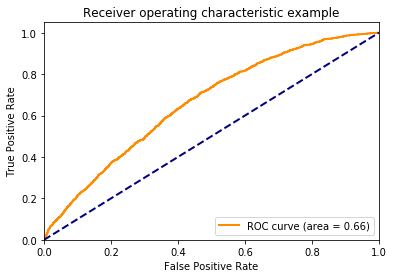

In [31]:
#plot ROC curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

try smaller set of variables

In [32]:
X = df2mx[['age','intubate','neumonia','hyperten','ICU', 'COVID']]
y = df2mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

#ROC
y_prob = lr.predict_proba(X)
fpr, tpr, _ = roc_curve(y, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)



0.8896329365079365
0.11036706349206349
0.8085721111136497


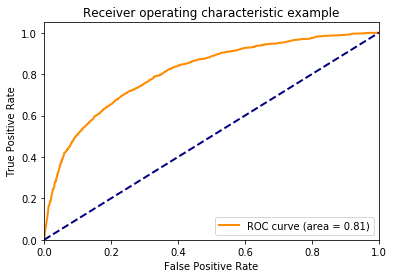

In [33]:
#plot ROC curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

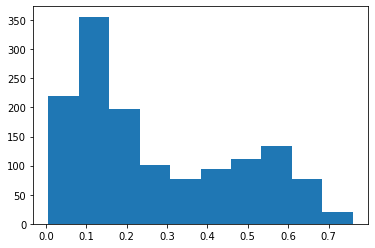

In [34]:
plt.hist(y_prob[y ==1,1]);

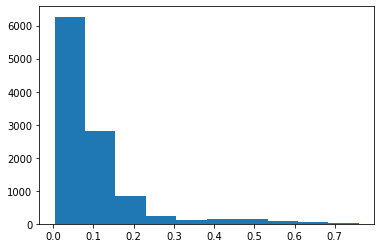

In [35]:
plt.hist(y_prob[y ==0,1]);

nearly the same R2 but very different ROC and AUC

In [36]:
#Wow, that's explains almost all of the variability in deaths (88%).
#What variables are influencial?

#log odds ratio
print(lr.coef_)

#odds ratio
print(np.exp(lr.coef_))

[[ 0.02388187 -1.75367141 -0.58983704 -0.26372762 -0.18479181 -0.93983015]]
[[1.02416932 0.17313712 0.55441763 0.76818275 0.83127733 0.39069419]]


Intubate, Neumonia and COVID diagnosis are influencial but negative? coding 1,2

In [37]:
X = df3mx.iloc[:,:-1]
y = df3mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
#print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

#ROC
y_prob = lr.predict_proba(X)
fpr, tpr, _ = roc_curve(y, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9645222477720438
0.03547775222795622
0.7149800272784049


In [38]:
X = df3mx[['age','ambulatory','diabetes','neumonia','hyperten', 'COVID']]
y = df3mx['dead']

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X, y)
print(lr.coef_)
# print(lr.intercept_)
# print(y)
y_hat = lr.predict(X)
print(lr.score(X,y))
print(mean_squared_error(y,y_hat))

#ROC
y_prob = lr.predict_proba(X)
fpr, tpr, thresholds = roc_curve(y, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

# get the best threshold
# Youden Index (J)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
y_hatJ = (y_prob[:,1]>=best_thresh)*1
print('Best Threshold=%f' % (best_thresh))

print(mean_squared_error(y,y_hatJ))

[[ 0.02644144  2.43464036 -0.38377489 -0.81947568 -0.21460889 -1.02449724]]
0.9643209104684801
0.03567908953151989
0.9177243896450313
Best Threshold=0.021335
0.21418050419099494


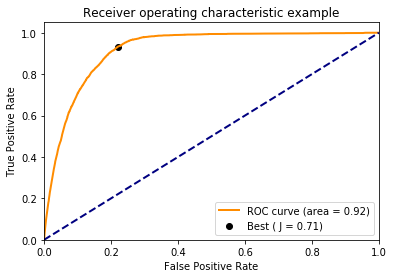

In [39]:
#plot ROC curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best ( J = %0.2f)' % J[ix])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Nearly same and much better R2 than the smaller dataset(df2mx) and again the AUC is way higher

I would drop those 3 highly incomplete variables rather than drop 80% rows.

In [40]:
CM = confusion_matrix(y, y_hatJ)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
print(PPV,TP,FP)
print(NPV,FN,TN)

0.13496082759814743 3118 19985
0.9968147503718463 227 71039


Using the threshold corresponding to the Youden Index 
we can corretly identify 90% of the people that will eventually die.
However, only 13% of the patients meeting the threshold will die, 
meaning that 87% will survive. 

This is good and bad. If a treatment is limited or burdensome, 
treating so many false positives is bad. 
If the treatment is extremely effective and avalable, then great.

## Train/Test Split

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=301)

In [42]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

y_hat = lr.predict(X_test)
print(lr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

#ROC
y_prob = lr.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9650311476462655
0.03496885235373451
0.9202473271759426


very close to full data model

...but what about normalization?

In [43]:
from sklearn.preprocessing import normalize

X_copy = X.copy()
X_norm = normalize(X_copy)
y_hat = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_norm, y).predict(X_norm)
mean_squared_error(y, y_hat)


0.035541332429081585

Didn't make a differnece

age is the only variable on a dif scale

0.9642623008724525

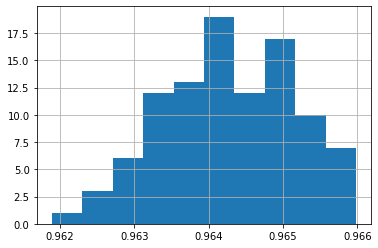

In [44]:
# Cross validation

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

reg = LogisticRegression(solver='lbfgs', max_iter=1000)
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=301)

s = cross_val_score(reg, X, y, cv=cv)
pd.Series(s).hist()
s.mean() # R^2


fairly robust to the choice of split

## K Nearest Neighbors

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier(K=1)
knnr = KNeighborsClassifier(n_neighbors=1)
knnr.fit(X_train, y_train)
y_hat = knnr.predict(X_test)
print(knnr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

#ROC
y_prob = knnr.predict_proba(X_test)
fpr, tpr, threshhold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9415901355083167
0.058409864491683255
0.5894683132777547


In [46]:
# KNN Classifier(K=10)
knnr = KNeighborsClassifier(n_neighbors=10)
knnr.fit(X_train, y_train)
y_hat = knnr.predict(X_test)
print(knnr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

#ROC
y_prob = knnr.predict_proba(X_test)
fpr, tpr, threshhold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9646458159398883
0.035354184060111746
0.8171102556756478


In [47]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter optimization:
# (Hyper)parameter grid
p_grid = {
    "n_neighbors": [1, 3, 5, 10, 15, 20, 50]
}

knnr = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knnr, param_grid=p_grid, 
                           cv=ShuffleSplit(n_splits=10, test_size=0.3, random_state=301), 
                           iid=False)
grid_search.fit(X, y)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=301, test_size=0.3, train_size=None),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [48]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.269063,0.015774,2.515160,0.066082,1,{'n_neighbors': 1},0.944686,0.941118,0.941931,0.947300,0.942213,0.940942,0.943308,0.939917,0.942849,0.941118,0.942538,0.002047,7
1,0.273003,0.010146,2.728454,0.066106,3,{'n_neighbors': 3},0.957684,0.955671,0.955282,0.959486,0.954541,0.954152,0.956413,0.953975,0.957578,0.956660,0.956144,0.001678,6
2,0.271595,0.007754,2.795485,0.074095,5,{'n_neighbors': 5},0.962806,0.960616,0.959203,0.961216,0.958991,0.957826,0.960899,0.957896,0.960051,0.959733,0.959924,0.001462,5
3,0.261907,0.017485,3.012639,0.077652,10,{'n_neighbors': 10},0.964643,0.963760,0.962523,0.964113,0.963195,0.963724,0.965102,0.962276,0.964678,0.962523,0.963654,0.000949,3
4,0.275207,0.011836,3.160106,0.085295,15,{'n_neighbors': 15},0.964537,0.964184,0.962453,0.964395,0.962877,0.963654,0.964961,0.962311,0.964395,0.962700,0.963647,0.000929,4
5,0.277733,0.028353,3.276093,0.076018,20,{'n_neighbors': 20},0.964961,0.964466,0.962735,0.964431,0.964466,0.964078,0.965879,0.963124,0.964961,0.963124,0.964222,0.000930,2
6,0.272953,0.008796,3.909149,0.095010,50,{'n_neighbors': 50},0.965420,0.964501,0.963195,0.964678,0.964466,0.964219,0.965985,0.963512,0.965102,0.963230,0.964431,0.000881,1


In [49]:
grid_search.best_params_

{'n_neighbors': 50}

In [50]:
# KNN Classifier(K=50) chose 20 bec R^2 is nearly identical
knnr = KNeighborsClassifier(n_neighbors=50)
knnr.fit(X_train, y_train)
y_hat = knnr.predict(X_test)
print(knnr.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

#ROC
y_prob = knnr.predict_proba(X_test)
fpr, tpr, threshhold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9649669256952026
0.03503307430479738
0.9044516469877774


nearly same as logistic regression but it took n=50 neighbors

## Deep Learning

In [51]:
#https://scikit-learn.org/stable/modules/neural_networks_supervised.html#

from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(solver='lbfgs', alpha=1e-10,
                        hidden_layer_sizes=(15, 2), random_state=301)
mlpc.fit(X_train, y_train)
y_hat = mlpc.predict(X_test)
print(mlpc.score(X_test,y_test))
print(mean_squared_error(y_test,y_hat))

#ROC
y_prob = mlpc.predict_proba(X_test)
fpr, tpr, threshhold = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9649669256952026
0.03503307430479738
0.920792962382526


## Ensamble Learning

In [52]:
#https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=None, 
                             min_samples_split=2,
                             random_state=301)
scores = cross_val_score(dtc, X, y, cv=5)
print(scores.mean())

rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=2,
                             random_state=301)
scores = cross_val_score(rfc, X, y, cv=5)
print(scores.mean())

etc = ExtraTreesClassifier(n_estimators=10, 
                           max_depth=None,
                           min_samples_split=2,
                           random_state=301)
scores = cross_val_score(etc, X, y, cv=5)
print(scores.mean())


0.9623605132809081
0.961576367460809
0.9624240944927047


In [53]:
#what if...we used the smaller dataset

X = df2mx.iloc[:,:-1]
y = df2mx['dead']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=301)

dtc = DecisionTreeClassifier(max_depth=None, 
                             min_samples_split=2,
                             random_state=301)
scores = cross_val_score(dtc, X, y, cv=5)
print(scores.mean())

rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=2,
                             random_state=0)
scores = cross_val_score(rfc, X, y, cv=5)
print(scores.mean())


etc = ExtraTreesClassifier(n_estimators=10, 
                           max_depth=None,
                           min_samples_split=2,
                           random_state=0)
scores = cross_val_score(etc, X, y, cv=5)
print(scores.mean())

0.39684860556407775
0.6898516906446555
0.8649983088428728


## DOH!

how we handle missing data matters